# Расчет близости текстов

In [ ]:
!nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Библиотеки

In [ ]:
import os
#from google.colab import drive
from tqdm import tqdm
import pickle

import pandas as pd
import numpy as np
from scipy import spatial

import torch
from sentence_transformers import SentenceTransformer, util

import matplotlib.pyplot as plt

# Предобученная модель

In [ ]:
#model = SentenceTransformer('bert-base-nli-mean-tokens') #эта быстрее
model = SentenceTransformer('bert-large-nli-mean-tokens') #эта точнее

# Датасет с embedding

In [ ]:
comments_dir = "/content/drive/My Drive/weights"
os.listdir(comments_dir)[:5]

['df_test.pickle', 'df_train.pickle']

Загружаем таблицу с уже посчитанными ембедингами и кластерами для двух подвыборок из редита

In [ ]:
%%time

with open(os.path.join(comments_dir, 'df_train.pickle'), mode='rb') as pandas_file:
    train_df = pickle.load(pandas_file)

Wall time: 1.54 s


In [ ]:
train_df

,author,body,created_utc,link_id,parent_id,score,who,embedding
0,kkkleina,"does not load for me either, iceland",1606337819,t3_k0zg1t,t1_gdl57gw,1,0.0,"[-0.5620464, -0.0044380575, 0.57985806, 0.1312..."
1,Mine_Darkness08,I swear if they try to twist this into orange ...,1579564912,t3_erfudx,t3_erfudx,1,0.0,"[0.52616477, 0.26897562, 0.55072683, 0.7936976..."
2,Son-of-Neleus,Probably joined the Black Panthers too,1601764899,t3_j42hw9,t1_g7i9o8c,1,0.0,"[1.1628835, -0.5586643, 0.5151502, 0.40808493,..."
3,Shelter-in-Space,"Holy shit this is dumb. 1) ""Dominion"" is just ...",1605737574,t3_jwpm04,t3_jwpm04,-23,0.0,"[0.26338562, -0.5902791, 0.5505226, -0.1255931..."
4,handpeople,He also said Big Mike did not have a dick and ...,1579197712,t3_epmwb6,t3_epmwb6,1,0.0,"[0.7837271, 0.46787333, 0.6279784, -0.34672, 0..."
...,...,...,...,...,...,...,...,...
99995,nevertulsi,I do not think her AG record is trash. I think...,1591991340,t3_h7qb28,t1_fumjk0x,1,1.0,"[0.6386456, -0.51033837, 0.09939509, 0.4628307..."
99996,YourUndoing,My dad has literally (without sarcasm or tryin...,1607985339,t3_kd12mo,t1_gftyph9,1,1.0,"[0.6974588, 0.39496022, 0.46409717, -0.7663132..."
99997,R3dRuby,Every older person in my family despises Trump...,1599674858,t3_iph1sz,t1_g4k3diy,1,1.0,"[0.31154042, -0.33243722, 0.62614083, 0.370053..."
99998,Ode_to_bees,This breaks my heart. I am in NJ and we went t...,1596476798,t3_i2z83p,t3_i2z83p,1,1.0,"[0.6527439, 0.70839363, 0.73180544, 0.44795087..."


In [ ]:
trump_df = train_df[train_df['who'] == 0][['body', 'who', 'embedding']].sample(10000)
biden_df = train_df[train_df['who'] == 1][['body', 'who', 'embedding']].sample(10000)
all_df = train_df[['body', 'who', 'embedding']].sample(10000)

In [ ]:
print(trump_df.shape)

(10000, 3)


# Создаем искуственную выборку c лозунгами за Трампа

In [ ]:
ref_texts = (
'This is why we need Trump to win. With the USA as  trendsetter, we can purge the traitors from office!',
'Bitcoin will soon be called Trump Coin it’ll be so great!',
'Daddy Trump is gonna make Daycare Great Again!',
'they was hoping trump would give them a boost in california. the tears are delicious',
'Flawless Centipede... Submit to @Twinksfortrump and follow @Gay4Trump',
'But if Bernie debates trump and a meteorite hit Hillary then sanders will win! Remember guys phone bank, donate, match me',
'edited because i was a tool, and edited to say LostTrumpSupporter is AWESOME!',
'my best tips are almost always from trump supporters. i guess when youre employed you can afford to be a generous person',
'And it will work, until Trump makes America so fucking awesome nobody would want to change it.',
'Poseidon is doing his best to protect the West.  Thank you based Poseidon.',
'Trump/Poseidon 2016',
'Probably made a script to respond to all of Trump’s newest tweets with pre-written tweets. He’s an impressive centipede!',
'Donald Trump is best',
'Trump has a diet for this country and trust me it’s gonna be nutritious and delicious',
'Mr. Trump all we do is win i need a break!',
'Babes are awesome so are Trump fellas.',
'That’s a cuck way of looking at it, Trump WILL WIN 50+DC!',
'Trump Tower has the best taco bowls.',
"immigrants are bad",
"Immigrants will take American jobs, lower our wages, and especially hurt the poor",
"Immigrants abuse the welfare state",
"Immigrants increase the budget deficit and government debt",
"Immigrants increase economic inequality",
"Today’s immigrants don’t assimilate like immigrants from previous waves did",
"Immigrants are a major source of crime",
"Immigrants pose a unique risk today because of terrorism",
"It’s easy to immigrate to America and we’re the most open country in the world",
"Amnesty or a failure to enforce our immigration laws will destroy the Rule of Law in the United States",
"By not exercising control over borders through actively blocking immigrants, the users of this argument warn, the United States government will surrender a vital component of its national sovereignty",
"Immigrants won’t vote for the Republican Party",
"Immigrants bring with them their bad cultures, ideas, or other factors that will undermine and destroy our economic and political institutions.  The resultant weakening in economic growth means that immigrants will destroy more wealth than they will create over the long run",
"The brain drain of smart immigrants to the United State impoverished other countries",
"Immigrants will increase crowding, harm the environment",
'Hey man im in north jersey as well. I wear my MAGA gear with pride and drive around with my trump bumper sticker. Im in morris county. Dont let the libs win. Trump 2016!!!',
'I’m not asking for a VP that is lockstep with Trump. But accepting a VP who was a prime mover in the passage of one of the greatest frauds foisted upon the US ever is NOT acceptable as VP. VP is a heartbeat from POTUS',
'The official Donald Trump MAGA cap is the one the Don himself wears. It’s the one I bought, and let me tell you folks, it is the best hat around, the best, believe me.'
)

ref_vec = model.encode(ref_texts, show_progress_bar=True, convert_to_numpy=True, device='cuda')

ref_df = pd.DataFrame({'body': ref_texts, 'embedding':list(ref_vec)})

# Сраваниваем заданное предложение с подвыборками

In [ ]:
#Compute embeddings for the sentence we want to compare
query = 'This is why we need Trump to win. With the USA as  trendsetter, we can purge the traitors from office!'
query_vec = model.encode(query, show_progress_bar=True, convert_to_numpy=True, device='cuda')

считаем расстояния между заданным предложением и 4мя выборками

In [ ]:
%%time
# Trump
trump_scores = list()
for vec in list(trump_df['embedding']):
    trump_scores.append(1 - spatial.distance.cosine(vec, query_vec))
trump_df['similarity'] = trump_scores

# Biden
biden_scores = list()
for vec in list(biden_df['embedding']):
    biden_scores.append(1 - spatial.distance.cosine(vec, query_vec))
biden_df['similarity'] = biden_scores

# All
all_scores = list()
for vec in list(all_df['embedding']):
    all_scores.append(1 - spatial.distance.cosine(vec, query_vec))
all_df['similarity'] = all_scores

# Ref
all_scores = list()
for vec in list(ref_df['embedding']):
    all_scores.append(1 - spatial.distance.cosine(vec, query_vec))
ref_df['similarity'] = all_scores

Wall time: 1.28 s


топ-5 близких предложений из 3 выборок к заданному предложению

In [ ]:
list(trump_df.sort_values('similarity', ascending=False)[:5]['body'])

['Trump himself saving T_D! Leftists may rule reddit but at least T_D has one advantage.',
 'What has Donald Trump done to help hold criminal police accountable when they are caught breaking the law?',
 'I suspect that the next liberal president will also use the EO. And I will complain about it. Call me a fucking hypocrite. Trump is doing it to save the nation',
 'Exactly. I am not holding my breath. Hope he votes Trump, I guess. Also hope Chelsea "Slavemaster Bitch" Handler does not threaten him, too.',
 'is not ironic that Trump is saving the country in Gettysburg? I bet Lincoln is looking down and smiling. After Trump saves the Republic he should start charging democrats involved with Treason.']

In [ ]:
list(biden_df.sort_values('similarity', ascending=False)[:5]['body'])

['a progressive agenda? really? we will be *lucky* to have a country if Trump becomes president. Just watch. China and Europe and Russia will Hiroshima the fuck out of us. Vote for Biden if you want global stability and a man who actually knows how to not make the Cold War get even worse!',
 'I mean, I would argue he understands and that is why he says we need to vote Trump out to save the country.',
 'I was happy to vote for Biden when the alternative was Trump, if you want to blame anyone for electing Biden blame the POTUS for being such an undesirable candidate.',
 'The fight against Trump goes well beyond differences in political ideology. Either we stand together as Americans or we will all watch this country fall. Well done.',
 'For real haha. If Trump wants to stop these riots, why does not he already? How would he respond differently if re-elected?']

In [ ]:
list(all_df.sort_values('similarity', ascending=False)[:5]['body'])

['Former Berner here, you are making the responsible choice. let us crush Donald Trump and never have to deal with a disaster like this pandemic again!!',
 'we are past Biden or Trump, because Trump won. it is now a matter of preventing the steal by recounting, auditing and proving the fraud in court. After that it is time to arrest a lot of people and drain the swamp.',
 "Great to know that CBS is no longer 'Fake News'! So [here is]( a great article from them on why Trumps' claims of election interference are false :- ) ",
 'Exactly. I am not holding my breath. Hope he votes Trump, I guess. Also hope Chelsea "Slavemaster Bitch" Handler does not threaten him, too.',
 'But not before burning up any goodwill he had for voting for Trump’s impeachment. Well played.']

In [ ]:
list(ref_df.sort_values('similarity', ascending=False)[:5]['body'])

['This is why we need Trump to win. With the USA as  trendsetter, we can purge the traitors from office!',
 'But if Bernie debates trump and a meteorite hit Hillary then sanders will win! Remember guys phone bank, donate, match me',
 'Mr. Trump all we do is win i need a break!',
 'And it will work, until Trump makes America so fucking awesome nobody would want to change it.',
 'they was hoping trump would give them a boost in california. the tears are delicious']

Смотрим среднее расстояние

In [ ]:
print('Среднее расстояние до выборки трампа:', trump_df['similarity'].mean())
print('Среднее расстояние до выборки байдена:', biden_df['similarity'].mean())
print('Среднее расстояние до смешанной выборки:', all_df['similarity'].mean())
print('Среднее расстояние до маяка:', ref_df['similarity'].mean())

Среднее расстояние до выборки трампа: 0.5140972476486583
Среднее расстояние до выборки байдена: 0.5270592045970262
Среднее расстояние до смешанной выборки: 0.5214326671561226
Среднее расстояние до маяка: 0.5913257905178599


Смотрим среднее расстояние

In [ ]:
print('Макс расстояние до выборки трампа:', trump_df['similarity'].max())
print('Макс расстояние до выборки байдена:', biden_df['similarity'].max())
print('Макс расстояние до смешанной выборки:', all_df['similarity'].max())
print('Макс расстояние до маяка:', ref_df['similarity'].max())

Макс расстояние до выборки трампа: 0.8208584189414978
Макс расстояние до выборки байдена: 0.8486796617507935
Макс расстояние до смешанной выборки: 0.8349440693855286
Макс расстояние до маяка: 1.0


Посмотрим на распределение расстояния

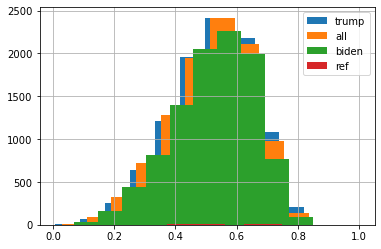

In [ ]:
trump_df['similarity'].hist(label='trump')
all_df['similarity'].hist(label='all')
biden_df['similarity'].hist(label='biden')
ref_df['similarity'].hist(label='ref')
plt.legend()